In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

--2021-12-06 16:51:34--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  50.2MB/s    in 5.1s    

2021-12-06 16:51:39 (46.5 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [1]:
import os
import time
import copy


import torch
import torchvision
import torch.nn as nn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import PIL

import os
import random
import tqdm

In [2]:


# from utils import helper_plot

if torch.cuda.is_available():
    # you can continue going on here, like cuda:1 cuda:2....etc.
    DEVICE = torch.device("cuda:0")
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")

# Constants
DATA_DIR = "tiny-imagenet-200"
VAL_DIR = "tiny-imagenet-200/val"
VAL_IMG_DIR = "tiny-imagenet-200/val/images"

preprocess_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

preprocess_val = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
])

# test_transforms = torchvision.transforms.Compose([
#     torchvision.transforms.Resize(224),
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
# ])

train_dataset = torchvision.datasets.ImageFolder(
    "tiny-imagenet-200/train", transform=preprocess_train)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, drop_last=True)

# Place corresponding images into respective folders
val_info = pd.read_csv("tiny-imagenet-200/val/val_annotations.txt",
                       sep='\t', header=None, names=["File", "Class", "X", "Y", "H", "W"])
val_info.drop(["X", "Y", "H", "W"], axis=1, inplace=True)
for img, folder_name in zip(val_info["File"], val_info["Class"]):
    newpath = os.path.join(VAL_IMG_DIR, folder_name)
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(VAL_IMG_DIR, img)):
        os.rename(os.path.join(VAL_IMG_DIR, img), os.path.join(newpath, img))

val_dataset = torchvision.datasets.ImageFolder(
    "tiny-imagenet-200/val/images", transform=preprocess_val)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=128, shuffle=True, drop_last=True)


Running on the GPU


In [3]:
def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()


def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.features[layer_num]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.features[layer_num].weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")

In [4]:
dataloader = {
    "train": train_dataloader,
    "test": val_dataloader
}
datasize = {
    "train": len(train_dataset),
    "test": len(val_dataset)
}

In [5]:
def train_model(model, criterion, optimizer, scheduler, epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_top5 = 0.0
    
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch, epochs-1))
        print("-"*10)
        
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0 
            running_top5 = 0
            

            with tqdm.tqdm(dataloader[phase], unit="batch") as bar:
            # Iterate over data
                for inputs, labels in bar:
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)
                    
                    # Zero the parametsrs
                    optimizer.zero_grad()
                    
                    # Forward
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
                        
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    # Calculating TOP 5 accuracy
                    top5_values = torch.topk(outputs, k=5)
                    # print("Label Size: {}, Top 5: {}".format(labels.size(), top5_values[0].size()))
                    for i in range(labels.size(0)):
                        if labels[i] in top5_values[1][i]:
                          running_top5  = running_top5 + 1.0
                    
                    bar.set_postfix(loss=loss.item())
                
                if phase == "train":
                    scheduler.step()
                
                epoch_loss = running_loss / datasize[phase]
                epoch_acc = running_corrects.double()/datasize[phase]
                epoch_top5 = running_top5 / datasize[phase]
                
                print()
                print("{} Loss: {:.4f} Acc: {:.4f} Top 5 Acc: {:.4f}".format(phase, epoch_loss, epoch_acc, epoch_top5))
                # bar.set_description(Phase=phase)
                # bar.set_postfix(epoch_loss=epoch_loss, epoch_acc=epoch_acc)
                if(phase == "test" and epoch_acc > best_acc):
                    best_acc = epoch_acc
                    best_top5 = epoch_top5
                    best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print("Training complete in {:0f}m {:0f}s".format(time_elapsed//60, time_elapsed%60))
    print("Best val Acc: {}:4f \nBest val top 5: {}:4f".format(best_acc, best_top5))
    
    # load best model parameters
    model.load_state_dict(best_model_wts)
    return model

In [6]:
model = torchvision.models.resnet18(pretrained=True)

# turn training false for all layers, other than fc layer
for param in model.parameters():
    param.requires_grad = False
    
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(train_dataset.classes))
model = model.to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model.parameters(), lr=0.005)
exp_lr_sc = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [29]:
model.load_state_dict(torch.load("resnet_final.pt"))
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
model = train_model(model, criterion, optimizer_ft, exp_lr_sc, epochs=1)

Epoch 0/0
----------


100%|██████████| 781/781 [05:00<00:00,  2.60batch/s, loss=3.06]



train Loss: 3.4770 Acc: 0.2977 Top 5 Acc: 0.5278


100%|██████████| 78/78 [00:30<00:00,  2.52batch/s, loss=2.73]


test Loss: 2.6786 Acc: 0.4026 Top 5 Acc: 0.6572

Training complete in 5.000000m 31.606889s
Best val Acc: 0.4026:4f 
Best val top 5: 0.6572:4f


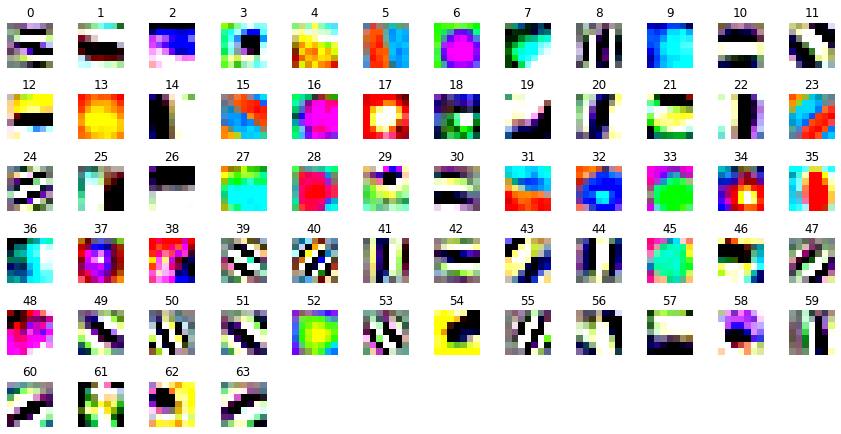

In [12]:
weight_tensor = model.conv1.weight.data
plot_filters_multi_channel(weight_tensor.cpu())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


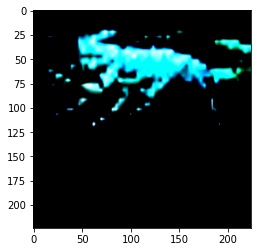

In [53]:
img_path = "tiny-imagenet-200/train/n01770393/images/n01770393_102.JPEG"
img = PIL.Image.open(img_path)
img = preprocess_train(img)
plt.imshow(np.transpose(img, (1, 2, 0)))

In [74]:
img_tensor = img.unsqueeze(0).to(DEVICE)

In [90]:
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")

Total convolution layers: 17


In [100]:
image = img_tensor
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
    print("Done ",layer)
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

Done  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Done  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Done  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Done  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Done  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Done  Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Done  Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Done  Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Done  Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Done  Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Done  Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Done  Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=

In [101]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(14, 14)
(14, 14)
(14, 14)
(14, 14)


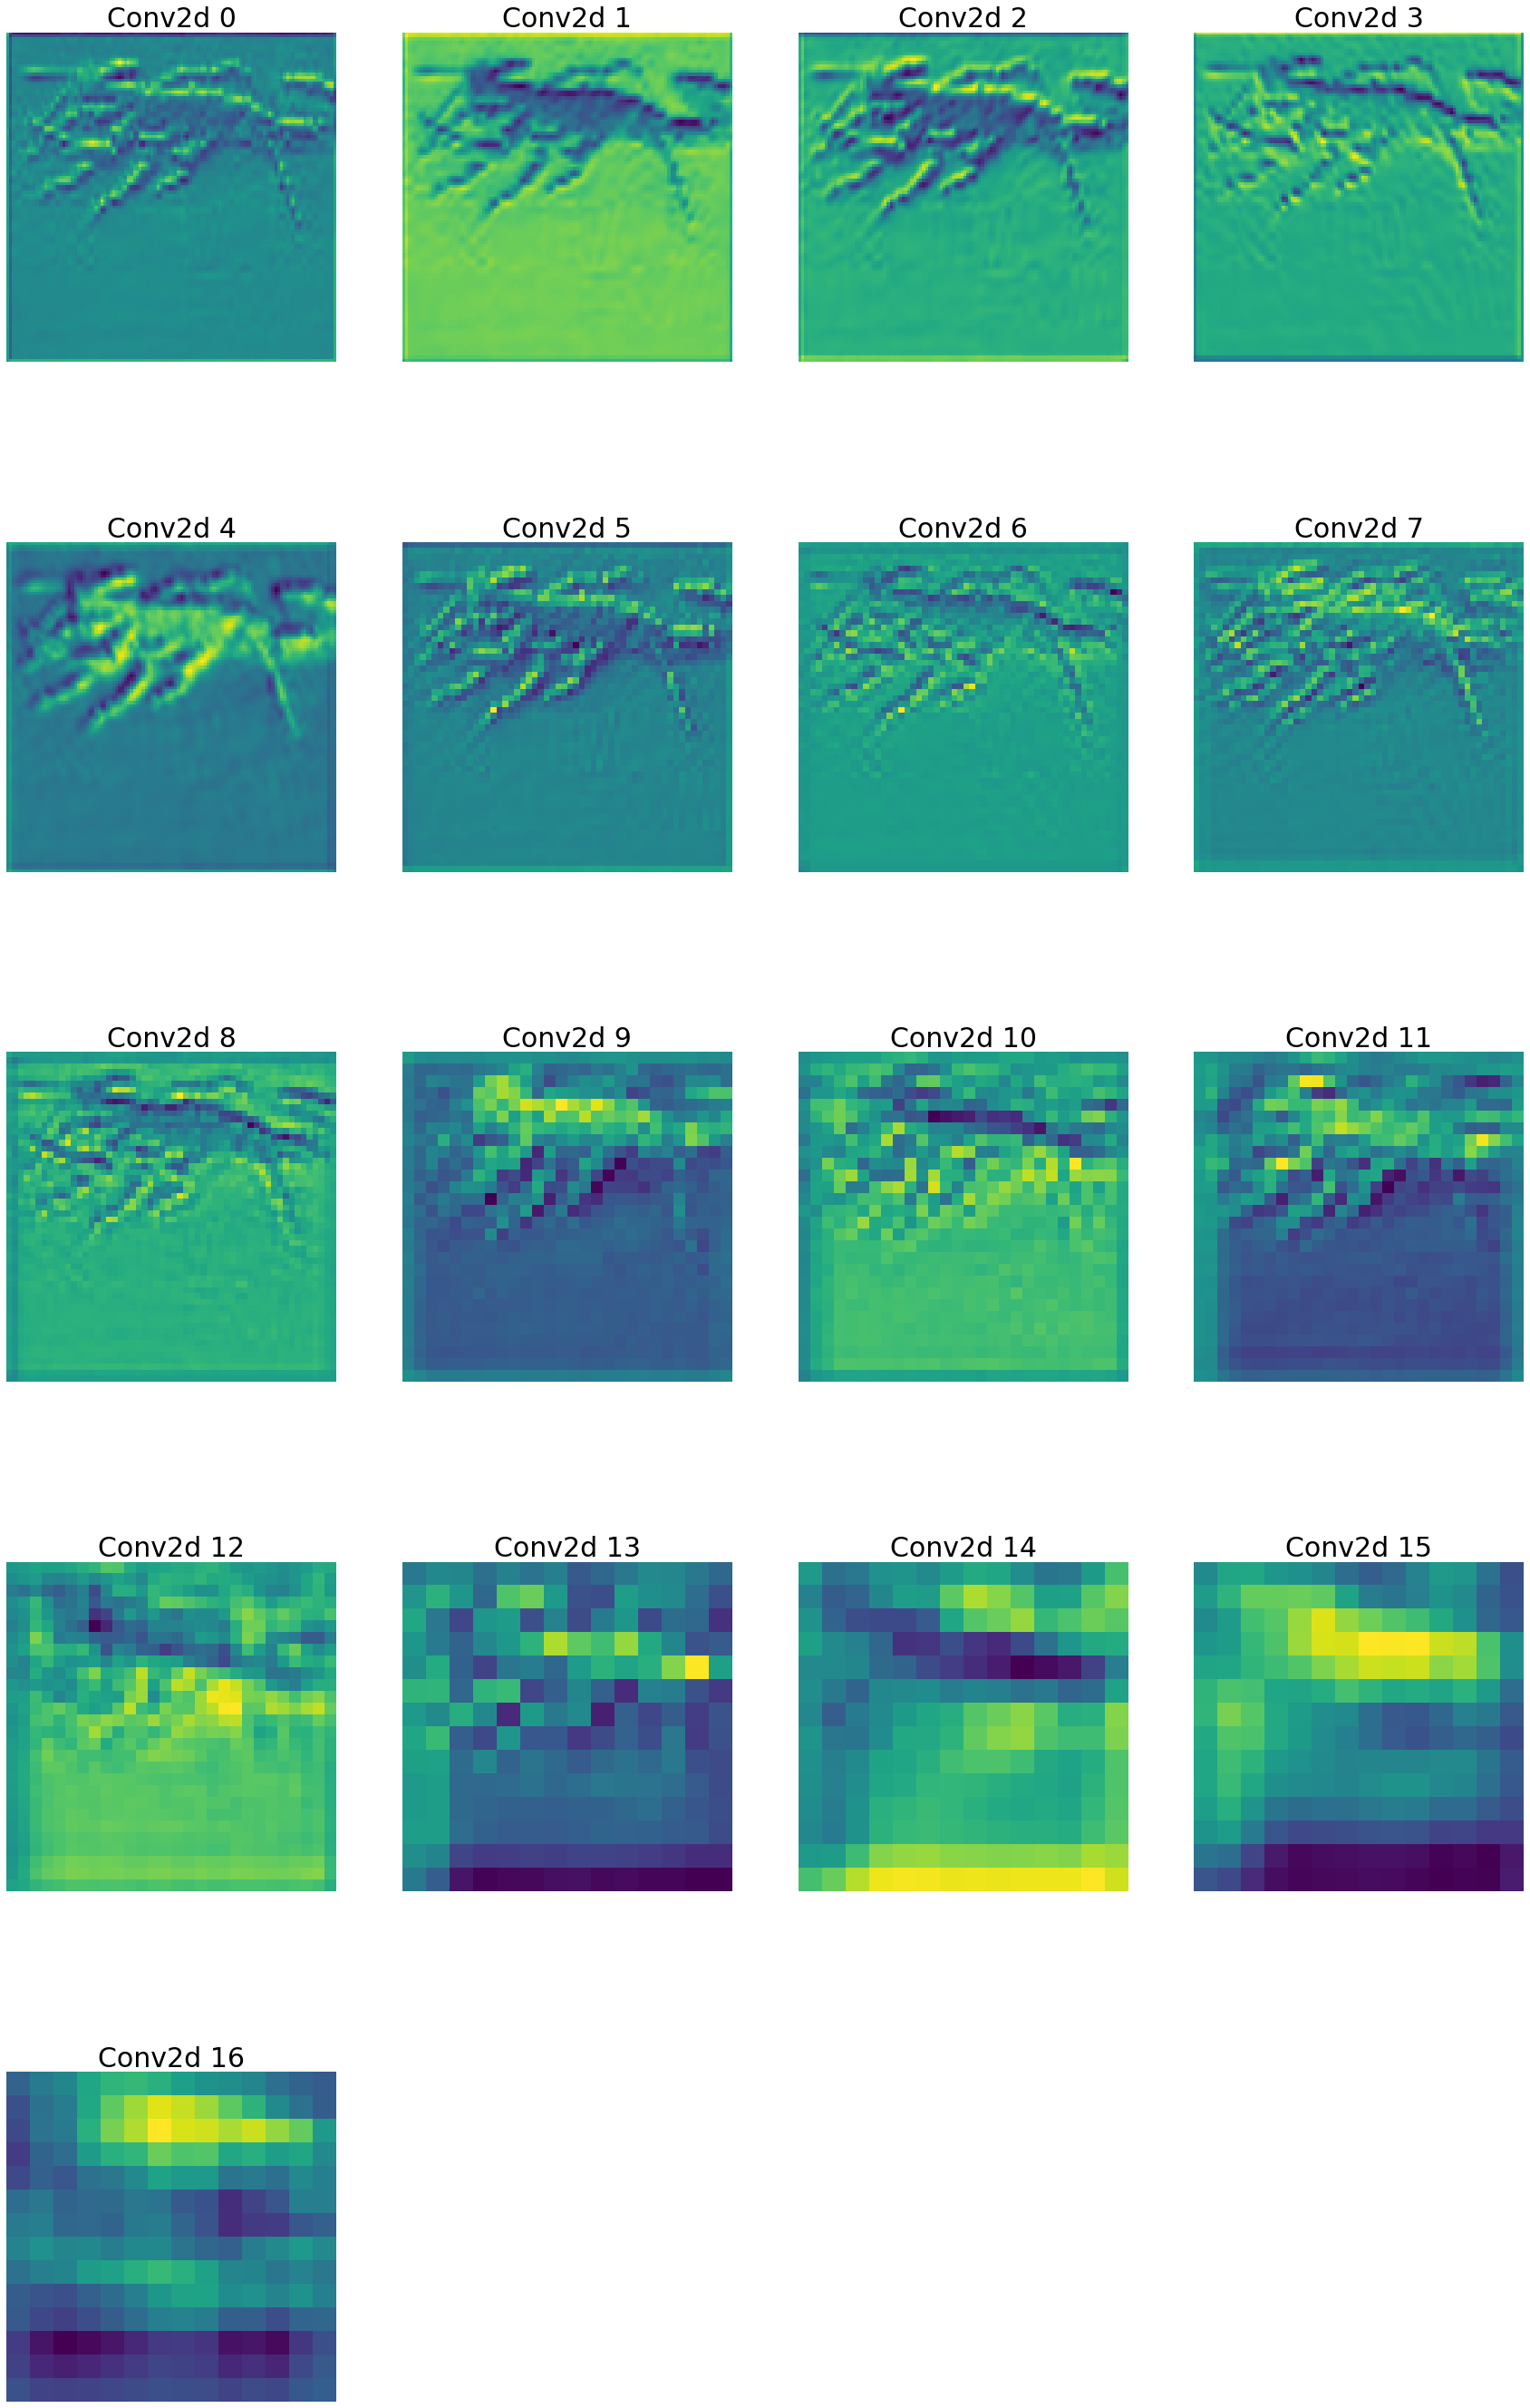

In [108]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0] + " "+str(i), fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [ ]:
torch.save(model.state_dict(), "resnet_final.pt")